# Može li nam program opisati film?

In [53]:
!python -m spacy validate

C:\Users\lkrpan\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2

| Loading compatibility table...

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

/ Loading compatibility table...


- Loading compatibility table...
[+] Loaded compatibility table

================= Installed pipeline packages (spaCy v3.3.1) =================
[i] spaCy installation: C:\Users\lkrpan\Anaconda3\lib\site-packages\spacy

NAME             SPACY                 VERSION      
en_core_web_sm   >=3.3.0.dev0,<3.4.0   3.3.0     [+]



# Characters
Character tracking is another key goal of *Moviegoer*. We can identify and compile information on individual characters. We'll keep looking at the romantic comedy *Plus One* (2019). Again, check the Readme in this directory root for illustrations to follow along.

In [52]:
import pandas as pd
pd.__version__
#!python --version

'1.4.2'

In [13]:
import os
import sys
sys.path.append('../venv/lib/python3.6/site-packages')
sys.path.append('../vision_features')
from vision_dataframes_io import *
from deepface import DeepFace
import pandas as pd

"""
performs emotion recognition where primary faces are listed as found in face_df
to use, change film
"""

film = 'margaux'

'''change above parameters'''


def get_primary_char_emotion(film, frame_number):
    frame_folder = os.path.join('../frame_per_second', film)
    img_path = frame_folder + '/' + film + '_frame_' + str(frame_number) + '.jpg'

    obj = DeepFace.analyze(img_path, actions=['emotion'], enforce_detection=False)
    return obj["dominant_emotion"]


serialized_object_directory = '../serialized_objects/'
film_directory = os.path.join(serialized_object_directory, film)

face_df = pd.read_pickle(os.path.join(film_directory, 'face_df_pre_emotion.pkl'))

prim_char_flags = face_df.prim_char_flag.tolist()
frame_list = face_df.index.tolist()

p_emotions_visual = []
x = 0

for flag in prim_char_flags:
    if flag == 1:
        p_emotions_visual.append(get_primary_char_emotion(film, frame_list[x]))
    elif flag == 0:
        p_emotions_visual.append(None)
    x += 1

face_df['p_emotion'] = p_emotions_visual
face_df.to_pickle(os.path.join(film_directory, 'face_df.pkl'))




1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 19ms/step


In [12]:
import os
import sys
sys.path.append('../data_serialization')
from serialization_preprocessing_io import *
import pandas as pd
sys.path.append('../subtitle_features')
from subtitle_dataframes_io import *

"""
performs clustering of frames (from saved numpy file of VGG16 vectorizations) and faces (from pickled face_df dataframe)
to use, change film
"""

film = 'margaux'

'''change above parameters'''

serialized_object_directory = '../serialized_objects/'
film_directory = os.path.join(serialized_object_directory, film)
vision_df = pd.read_pickle(os.path.join(film_directory, 'vision_df_pre_cluster.pkl'))
face_df = pd.read_pickle(os.path.join(film_directory, 'face_df_pre_cluster.pkl'))

face_df_clustered = cluster_primary_faces(face_df)
vision_df_clustered = cluster_shots(film, vision_df)

face_df_clustered.to_pickle(os.path.join(film_directory, 'face_df_pre_emotion.pkl'))
vision_df_clustered.to_pickle(os.path.join(film_directory, 'vision_df.pkl'))

sentence_df = pd.read_pickle(os.path.join(film_directory, 'sentence_df_pre_cluster.pkl'))
subtitle_df = pd.read_pickle(os.path.join(film_directory, 'subtitle_df.pkl'))
sentence_df = generate_speakers(sentence_df, subtitle_df, face_df)
sentence_df.to_pickle(os.path.join(film_directory, 'sentence_df.pkl'))


In [6]:
import os
import sys
sys.path.append('../venv/lib/python3.6/site-packages')
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

"""
uses VGG16 image recognition model to vectorize image files and exports to a single numpy file
does not work on animated movies
to be run in Docker container to take advantage of GPU, using "tensorflow:latest-gpu" Docker image
to use, change film and frame_choice
"""

film = 'margaux'
frame_choice = range(1, 6247)   # (1, number of frame files plus one)

'''change above parameters'''

serialized_object_directory = '../serialized_objects/'
film_directory = os.path.join(serialized_object_directory, film)

image_directory = '../frame_per_second/'
print(os.path.join(image_directory, film))

model = VGG16(weights='imagenet', include_top=False)

vgg16_feature_list = []

for x in frame_choice:
    img_path = os.path.join(image_directory, film) + '/' + film + '_frame_' + str(x) + '.jpg'
    print(img_path)
    img = image.load_img(img_path, target_size=(256, 256))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())

    x += 1

vgg16_feature_list_np = np.array(vgg16_feature_list)

print(vgg16_feature_list_np.shape)

np.save(os.path.join(film_directory, 'vgg16_features.npy'), vgg16_feature_list_np)


../frame_per_second/margaux
../frame_per_second/margaux/margaux_frame_1.jpg
1/1 [==============================] - 4s 4s/step
../frame_per_second/margaux/margaux_frame_2.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_3.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_4.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_5.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_6.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_7.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_8.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_9.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_10.jpg
1/1 [=====================

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_83.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_84.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_85.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_86.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_87.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_88.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_89.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/margaux/margaux_frame_90.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_91.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_9

1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_164.jpg
1/1 [==============================] - 0s 29ms/step
../frame_per_second/margaux/margaux_frame_165.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_166.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_167.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_168.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_169.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_170.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_171.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_172.jpg
1/1 [==============================] - 0s 29ms/step
../frame_per_second/margaux/mar

1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_244.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_245.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_246.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_247.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_248.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_249.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_250.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_251.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_252.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/ma

../frame_per_second/margaux/margaux_frame_324.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_325.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/margaux/margaux_frame_326.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_327.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_328.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_329.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_330.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_331.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_332.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_333.jpg
1/1 [===========================

1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_405.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_406.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_407.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_408.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_409.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_410.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_411.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_412.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_413.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/marg

../frame_per_second/margaux/margaux_frame_485.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_486.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_487.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_488.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_489.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_490.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/margaux/margaux_frame_491.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_492.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_493.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_494.jpg
1/1 [===========================

1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_566.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_567.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_568.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_569.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_570.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_571.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_572.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_573.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_574.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/marga

1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_647.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_648.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_649.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_650.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_651.jpg
1/1 [==============================] - 0s 29ms/step
../frame_per_second/margaux/margaux_frame_652.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_653.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_654.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_655.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/ma

../frame_per_second/margaux/margaux_frame_727.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_728.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_729.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_730.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_731.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_732.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_733.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_734.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_735.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_736.jpg
1/1 [==============================]

1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_808.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_809.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_810.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_811.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_812.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_813.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_814.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_815.jpg
1/1 [==============================] - 0s 27ms/step
../frame_per_second/margaux/margaux_frame_816.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margau

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_889.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_890.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_891.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_892.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_893.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_894.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_895.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_896.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_897.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_970.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_971.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_972.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_973.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_974.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_975.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_976.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_977.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_978.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/marga

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1050.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_1051.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_1052.jpg
1/1 [==============================] - 0s 27ms/step
../frame_per_second/margaux/margaux_frame_1053.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_1054.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1055.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_1056.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1057.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_1058.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_1130.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_1131.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1132.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_1133.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_1134.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_1135.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1136.jpg
1/1 [==============================] - 0s 26ms/step
../frame_per_second/margaux/margaux_frame_1137.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1138.jpg
1/1 [==============================] - 0s 29ms/step
../frame_per_second/m

1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_1210.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_1211.jpg
1/1 [==============================] - 0s 26ms/step
../frame_per_second/margaux/margaux_frame_1212.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_1213.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_1214.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_1215.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_1216.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_1217.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1218.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/ma

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_1290.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_1291.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1292.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_1293.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1294.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_1295.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1296.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_1297.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_1298.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/marga

1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_1370.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1371.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_1372.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1373.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1374.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1375.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_1376.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1377.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_1378.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_1450.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1451.jpg
1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_1452.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1453.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1454.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_1455.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1456.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_1457.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1458.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/m

1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_1530.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_1531.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_1532.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1533.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_1534.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1535.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1536.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_1537.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1538.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1610.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_1611.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1612.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1613.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1614.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_1615.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1616.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_1617.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1618.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margau

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_1690.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_1691.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_1692.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_1693.jpg
1/1 [==============================] - 0s 32ms/step
../frame_per_second/margaux/margaux_frame_1694.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_1695.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1696.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_1697.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1698.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_1770.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_1771.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_1772.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1773.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_1774.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_1775.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_1776.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_1777.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1778.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_1850.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1851.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1852.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_1853.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1854.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1855.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1856.jpg
1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_1857.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1858.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/m

1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_1930.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_1931.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1932.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1933.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_1934.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1935.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_1936.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_1937.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_1938.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_2010.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_2011.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_2012.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2013.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_2014.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2015.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2016.jpg
1/1 [==============================] - 0s 31ms/step
../frame_per_second/margaux/margaux_frame_2017.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_2018.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_2090.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2091.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_2092.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2093.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_2094.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2095.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_2096.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2097.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2098.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margau

1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_2170.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2171.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_2172.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_2173.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_2174.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2175.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2176.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2177.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2178.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_2250.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2251.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_2252.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2253.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_2254.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2255.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_2256.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_2257.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2258.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/marga

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2330.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_2331.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_2332.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2333.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_2334.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2335.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2336.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2337.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_2338.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/ma

1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_2410.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_2411.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2412.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2413.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_2414.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2415.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_2416.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2417.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_2418.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_2490.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2491.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_2492.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_2493.jpg
1/1 [==============================] - 0s 27ms/step
../frame_per_second/margaux/margaux_frame_2494.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_2495.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/margaux/margaux_frame_2496.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2497.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_2498.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/m

1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_2570.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2571.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2572.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2573.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_2574.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2575.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_2576.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_2577.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_2578.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/ma

1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_2650.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2651.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_2652.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2653.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2654.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2655.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2656.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2657.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_2658.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2730.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2731.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_2732.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_2733.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2734.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2735.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2736.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_2737.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2738.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/ma

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2810.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2811.jpg
1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_2812.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2813.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2814.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_2815.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_2816.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_2817.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2818.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_2890.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2891.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_2892.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2893.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_2894.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_2895.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_2896.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_2897.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_2898.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/ma

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2970.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_2971.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_2972.jpg
1/1 [==============================] - 0s 27ms/step
../frame_per_second/margaux/margaux_frame_2973.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_2974.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_2975.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_2976.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_2977.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_2978.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/m

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3050.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_3051.jpg
1/1 [==============================] - 0s 31ms/step
../frame_per_second/margaux/margaux_frame_3052.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_3053.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_3054.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3055.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3056.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_3057.jpg
1/1 [==============================] - 0s 27ms/step
../frame_per_second/margaux/margaux_frame_3058.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3130.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_3131.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3132.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_3133.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3134.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3135.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3136.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3137.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3138.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/m

1/1 [==============================] - 0s 27ms/step
../frame_per_second/margaux/margaux_frame_3210.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_3211.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_3212.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_3213.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_3214.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_3215.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3216.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_3217.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_3218.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/m

1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_3290.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3291.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_3292.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3293.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_3294.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3295.jpg
1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_3296.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_3297.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3298.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margau

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3370.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_3371.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_3372.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_3373.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3374.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_3375.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_3376.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_3377.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_3378.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_3450.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3451.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_3452.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3453.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3454.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3455.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3456.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3457.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3458.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3530.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3531.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_3532.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_3533.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3534.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3535.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_3536.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3537.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3538.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/m

1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_3610.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3611.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3612.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_3613.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3614.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_3615.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3616.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3617.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3618.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_3690.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_3691.jpg
1/1 [==============================] - 0s 31ms/step
../frame_per_second/margaux/margaux_frame_3692.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_3693.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3694.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_3695.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_3696.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_3697.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3698.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3770.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_3771.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_3772.jpg
1/1 [==============================] - 0s 29ms/step
../frame_per_second/margaux/margaux_frame_3773.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_3774.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_3775.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3776.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_3777.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3778.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_3850.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_3851.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_3852.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3853.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_3854.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_3855.jpg
1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_3856.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_3857.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_3858.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_3930.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3931.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_3932.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_3933.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_3934.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_3935.jpg
1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_3936.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_3937.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_3938.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/marga

1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_4010.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_4011.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_4012.jpg
1/1 [==============================] - 0s 31ms/step
../frame_per_second/margaux/margaux_frame_4013.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_4014.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4015.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4016.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4017.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_4018.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_4090.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4091.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4092.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4093.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4094.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_4095.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4096.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_4097.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4098.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_4170.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4171.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4172.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4173.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_4174.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4175.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_4176.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_4177.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4178.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/marga

1/1 [==============================] - 0s 20ms/step
../frame_per_second/margaux/margaux_frame_4250.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_4251.jpg
1/1 [==============================] - 0s 31ms/step
../frame_per_second/margaux/margaux_frame_4252.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_4253.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4254.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_4255.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4256.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_4257.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_4258.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4330.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_4331.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4332.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_4333.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4334.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_4335.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4336.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4337.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_4338.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4410.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_4411.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4412.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_4413.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_4414.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4415.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_4416.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4417.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_4418.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_4490.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4491.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_4492.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4493.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_4494.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4495.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4496.jpg
1/1 [==============================] - 0s 28ms/step
../frame_per_second/margaux/margaux_frame_4497.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_4498.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_4570.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_4571.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4572.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_4573.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4574.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_4575.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4576.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_4577.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4578.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margau

1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_4650.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4651.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4652.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_4653.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4654.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_4655.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4656.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4657.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_4658.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_4730.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4731.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_4732.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4733.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_4734.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4735.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_4736.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4737.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_4738.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_4810.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_4811.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4812.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/margaux/margaux_frame_4813.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_4814.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4815.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_4816.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_4817.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_4818.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_4890.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4891.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_4892.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4893.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_4894.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4895.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_4896.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_4897.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_4898.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/marga

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4970.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_4971.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4972.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_4973.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4974.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_4975.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_4976.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_4977.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_4978.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/marga

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5050.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5051.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_5052.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5053.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5054.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5055.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_5056.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5057.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5058.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/m

1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_5130.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_5131.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_5132.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_5133.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_5134.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5135.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_5136.jpg
1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_5137.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/margaux/margaux_frame_5138.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_5210.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5211.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_5212.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5213.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_5214.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5215.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_5216.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_5217.jpg
1/1 [==============================] - 0s 19ms/step
../frame_per_second/margaux/margaux_frame_5218.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5290.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_5291.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5292.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_5293.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5294.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5295.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5296.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_5297.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5298.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5370.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_5371.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_5372.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5373.jpg
1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_5374.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5375.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_5376.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_5377.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5378.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5450.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5451.jpg
1/1 [==============================] - 0s 23ms/step
../frame_per_second/margaux/margaux_frame_5452.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5453.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_5454.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5455.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5456.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_5457.jpg
1/1 [==============================] - 0s 26ms/step
../frame_per_second/margaux/margaux_frame_5458.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/m

1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5530.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5531.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_5532.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_5533.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_5534.jpg
1/1 [==============================] - 0s 10ms/step
../frame_per_second/margaux/margaux_frame_5535.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5536.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_5537.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5538.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/mar

1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_5610.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_5611.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_5612.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5613.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_5614.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5615.jpg
1/1 [==============================] - 0s 2ms/step
../frame_per_second/margaux/margaux_frame_5616.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5617.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5618.jpg
1/1 [==============================] - 0s 13ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_5690.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_5691.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5692.jpg
1/1 [==============================] - 0s 7ms/step
../frame_per_second/margaux/margaux_frame_5693.jpg
1/1 [==============================] - 0s 30ms/step
../frame_per_second/margaux/margaux_frame_5694.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/margaux/margaux_frame_5695.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5696.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_5697.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5698.jpg
1/1 [==============================] - 0s 1ms/step
../frame_per_second/marga

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5770.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5771.jpg
1/1 [==============================] - 0s 0s/step
../frame_per_second/margaux/margaux_frame_5772.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5773.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5774.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5775.jpg
1/1 [==============================] - 0s 25ms/step
../frame_per_second/margaux/margaux_frame_5776.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_5777.jpg
1/1 [==============================] - 0s 29ms/step
../frame_per_second/margaux/margaux_frame_5778.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5850.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5851.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5852.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5853.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5854.jpg
1/1 [==============================] - 0s 6ms/step
../frame_per_second/margaux/margaux_frame_5855.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5856.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_5857.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5858.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/ma

1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_5930.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_5931.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5932.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_5933.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5934.jpg
1/1 [==============================] - 0s 5ms/step
../frame_per_second/margaux/margaux_frame_5935.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_5936.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_5937.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_5938.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 4ms/step
../frame_per_second/margaux/margaux_frame_6010.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_6011.jpg
1/1 [==============================] - 0s 11ms/step
../frame_per_second/margaux/margaux_frame_6012.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_6013.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_6014.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_6015.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_6016.jpg
1/1 [==============================] - 0s 8ms/step
../frame_per_second/margaux/margaux_frame_6017.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_6018.jpg
1/1 [==============================] - 0s 9ms/step
../frame_per_second/marg

1/1 [==============================] - 0s 18ms/step
../frame_per_second/margaux/margaux_frame_6090.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_6091.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_6092.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/margaux/margaux_frame_6093.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_6094.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_6095.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_6096.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_6097.jpg
1/1 [==============================] - 0s 3ms/step
../frame_per_second/margaux/margaux_frame_6098.jpg
1/1 [==============================] - 0s 16ms/step
../frame_per_second/ma

1/1 [==============================] - 0s 13ms/step
../frame_per_second/margaux/margaux_frame_6170.jpg
1/1 [==============================] - 0s 21ms/step
../frame_per_second/margaux/margaux_frame_6171.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_6172.jpg
1/1 [==============================] - 0s 24ms/step
../frame_per_second/margaux/margaux_frame_6173.jpg
1/1 [==============================] - 0s 12ms/step
../frame_per_second/margaux/margaux_frame_6174.jpg
1/1 [==============================] - 0s 17ms/step
../frame_per_second/margaux/margaux_frame_6175.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/margaux/margaux_frame_6176.jpg
1/1 [==============================] - 0s 22ms/step
../frame_per_second/margaux/margaux_frame_6177.jpg
1/1 [==============================] - 0s 15ms/step
../frame_per_second/margaux/margaux_frame_6178.jpg
1/1 [==============================] - 0s 14ms/step
../frame_per_second/m

In [5]:
import sys
import os
sys.path.append('../subtitle_features')
from subtitle_dataframes_io import *
from subtitle_auxiliary_io import *
sys.path.append('../vision_features')
from vision_dataframes_io import *
# sys.path.append('../audio_features')
# from audio_dataframes_io import *
sys.path.append('../unifying_features')
from time_reference_io import *
nlp = spacy.load('en_core_web_sm')

"""
creates base dataframes from image frames and subtitle file, and exports to pickle files
to use, place subtitle file in /subtitles/ and change film and frame_choice
"""

film = 'margaux'
frame_choice = range(1, 6247)   # (1, number of frame files plus one)

'''change above parameters'''

serialized_object_directory = '../serialized_objects/'
film_directory = os.path.join(serialized_object_directory, film)
#os.mkdir(film_directory)

# vision dataframes
face_df = generate_face_df(film, frame_choice)
face_df.to_pickle(os.path.join(film_directory, 'face_df_pre_cluster.pkl'))

vision_df = generate_vision_df(film, frame_choice)
vision_df.to_pickle(os.path.join(film_directory, 'vision_df_pre_cluster.pkl'))


# subtitle dataframes
subs_directory = '../subtitles/'
subs = pysrt.open(os.path.join(subs_directory, film + '.srt'))
srt_df = generate_srt_df(subs)
subtitle_df = generate_base_subtitle_df(subs)
subtitle_df = generate_subtitle_features(subtitle_df)
subtitle_df['cleaned_text'] = subtitle_df['concat_sep_text'].map(clean_line)
sentences = partition_sentences(remove_blanks(subtitle_df['cleaned_text'].tolist()), nlp)
subtitle_indices = tie_sentence_subtitle_indices(sentences, subtitle_df)
sentence_df = pd.DataFrame(list(zip(sentences, subtitle_indices)), columns=['sentence', 'subtitle_indices'])
sentence_df = generate_sentence_features(sentence_df, nlp)
subtitle_df = add_paren_offscreen_speaker(subtitle_df, sentence_df, nlp)

srt_df.to_pickle(os.path.join(film_directory, 'srt_df.pkl'))
subtitle_df.to_pickle(os.path.join(film_directory, 'subtitle_df.pkl'))
sentence_df.to_pickle(os.path.join(film_directory, 'sentence_df_pre_cluster.pkl'))


In [2]:
#6246
import cv2
import os

"""
extracts .jpg frames from a movie file and populates into /frame_per_second/ directory
extracts one .jpg per second of film
to use, place movie file in /input_videos/ and change title and optional scale_percent
"""

# create frames from video file
title = 'margaux'
scale_percent = 100     # no image scaling
# scale_percent = 44.44     # optional image scaling, 1080p to 480p

'''change above parameters'''

cap = cv2.VideoCapture('../input_videos/' + title + '.mkv')
# cap = cv2.VideoCapture('input_videos/' + title + '.mp4')
output_directory = os.path.join('../frame_per_second/', title)
#os.mkdir(output_directory)

if not cap.isOpened():
    print("Error opening video stream or file")

frame_rate = cap.get(5)              # frame rate
print('Video frame rate:', frame_rate)  # most movie files will have a frame_rate of 23.976 frames per second


# because of the 23.976 fps frame_rate, we can't just capture every 24 frames
count = 1   # starts at 1, because first image isn't saved until 25th frame (timestamp of 1.001 seconds)
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break
    if cap.get(0) / 1000 >= count:     # first frame after 1 second, 2 seconds, etc.
        filename = output_directory + '/' + title + '_frame_%d.jpg' % count

        # optional image scaling
        width = int(frame.shape[1] * scale_percent / 100)
        height = int(frame.shape[0] * scale_percent / 100)
        dimensions = (width, height)
        frame = cv2.resize(frame, dimensions)

        print(cap.get(0), cap.get(1), count)
        cv2.imwrite(filename, frame)
        count += 1

cap.release()
print('Extracted', count - 1, 'frames')


Video frame rate: 23.976
1001.0000000000001 25.0 1
2002.0000000000002 49.0 2
3003.0 73.0 3
4004.0000000000005 97.0 4
5005.0 121.0 5
6006.0 145.0 6
7007.000000000001 169.0 7
8008.000000000001 193.0 8
9009.0 217.0 9
10010.0 241.0 10
11011.000000000002 265.0 11
12012.0 289.0 12
13013.0 313.0 13
14014.000000000002 337.0 14
15015.0 361.0 15
16016.000000000002 385.0 16
17017.0 409.0 17
18018.0 433.0 18
19019.000000000004 457.0 19
20020.0 481.0 20
21021.0 505.0 21
22022.000000000004 529.0 22
23023.0 553.0 23
24024.0 577.0 24
25025.000000000004 601.0 25
26026.0 625.0 26
27027.0 649.0 27
28028.000000000004 673.0 28
29029.0 697.0 29
30030.0 721.0 30
31031.000000000004 745.0 31
32032.000000000004 769.0 32
33033.0 793.0 33
34034.0 817.0 34
35035.00000000001 841.0 35
36036.0 865.0 36
37037.0 889.0 37
38038.00000000001 913.0 38
39039.0 937.0 39
40040.0 961.0 40
41041.00000000001 985.0 41
42000.0 1008.0 42
43001.0 1032.0 43
44002.0 1056.0 44
45003.0 1080.0 45
46004.0 1104.0 46
47005.0 1128.0 47
48006

394019.0 9448.0 394
395020.0 9472.0 395
396021.0 9496.0 396
397022.0 9520.0 397
398023.0 9544.0 398
399024.0 9568.0 399
400025.00000000006 9592.0 400
401026.0 9616.0 401
402027.0 9640.0 402
403028.0 9664.0 403
404029.0 9688.0 404
405030.00000000006 9712.0 405
406031.0 9736.0 406
407032.0 9760.0 407
408033.0 9784.0 408
409034.0 9808.0 409
410035.0 9832.0 410
411036.0 9856.0 411
412037.00000000006 9880.0 412
413038.0 9904.0 413
414039.0 9928.0 414
415040.0 9952.0 415
416041.0 9976.0 416
417000.0 9999.0 417
418001.00000000006 10023.0 418
419002.0 10047.0 419
420003.0 10071.0 420
421004.0 10095.0 421
422005.0 10119.0 422
423006.0 10143.0 423
424007.0 10167.0 424
425008.0 10191.0 425
426009.0 10215.0 426
427010.0 10239.0 427
428011.0 10263.0 428
429012.0 10287.0 429
430013.00000000006 10311.0 430
431014.0 10335.0 431
432015.0 10359.0 432
433016.0 10383.0 433
434017.0 10407.0 434
435018.0 10431.0 435
436019.0 10455.0 436
437020.0 10479.0 437
438021.0 10503.0 438
439022.0 10527.0 439
440023.0

766016.0 18367.0 766
767017.0 18391.0 767
768018.0 18415.0 768
769019.0 18439.0 769
770020.0 18463.0 770
771021.0000000001 18487.0 771
772022.0 18511.0 772
773023.0 18535.0 773
774024.0 18559.0 774
775025.0 18583.0 775
776026.0000000001 18607.0 776
777027.0 18631.0 777
778028.0 18655.0 778
779029.0 18679.0 779
780030.0 18703.0 780
781031.0000000001 18727.0 781
782032.0 18751.0 782
783033.0 18775.0 783
784034.0 18799.0 784
785035.0 18823.0 785
786036.0 18847.0 786
787037.0 18871.0 787
788038.0 18895.0 788
789039.0 18919.0 789
790040.0 18943.0 790
791041.0 18967.0 791
792000.0 18990.0 792
793001.0 19014.0 793
794002.0000000001 19038.0 794
795003.0 19062.0 795
796004.0 19086.0 796
797005.0 19110.0 797
798006.0 19134.0 798
799007.0000000001 19158.0 799
800008.0 19182.0 800
801009.0 19206.0 801
802010.0 19230.0 802
803011.0 19254.0 803
804012.0 19278.0 804
805013.0 19302.0 805
806014.0 19326.0 806
807015.0 19350.0 807
808016.0 19374.0 808
809017.0 19398.0 809
810018.0 19422.0 810
811019.0 1

1123040.0 26927.0 1123
1124041.0 26951.0 1124
1125000.0 26974.0 1125
1126001.0 26998.0 1126
1127002.0 27022.0 1127
1128003.0 27046.0 1128
1129004.0000000002 27070.0 1129
1130005.0 27094.0 1130
1131006.0 27118.0 1131
1132007.0 27142.0 1132
1133008.0 27166.0 1133
1134009.0 27190.0 1134
1135010.0 27214.0 1135
1136011.0 27238.0 1136
1137012.0 27262.0 1137
1138013.0 27286.0 1138
1139014.0000000002 27310.0 1139
1140015.0 27334.0 1140
1141016.0 27358.0 1141
1142017.0 27382.0 1142
1143018.0 27406.0 1143
1144019.0 27430.0 1144
1145020.0 27454.0 1145
1146021.0 27478.0 1146
1147022.0 27502.0 1147
1148023.0 27526.0 1148
1149024.0 27550.0 1149
1150025.0 27574.0 1150
1151026.0 27598.0 1151
1152027.0 27622.0 1152
1153028.0 27646.0 1153
1154029.0 27670.0 1154
1155030.0 27694.0 1155
1156031.0 27718.0 1156
1157032.0 27742.0 1157
1158033.0000000002 27766.0 1158
1159034.0 27790.0 1159
1160035.0 27814.0 1160
1161036.0 27838.0 1161
1162037.0 27862.0 1162
1163038.0 27886.0 1163
1164039.0 27910.0 1164
1165040

1467009.0 35174.0 1467
1468010.0 35198.0 1468
1469011.0 35222.0 1469
1470012.0 35246.0 1470
1471013.0 35270.0 1471
1472014.0000000002 35294.0 1472
1473015.0 35318.0 1473
1474016.0 35342.0 1474
1475017.0 35366.0 1475
1476018.0 35390.0 1476
1477019.0 35414.0 1477
1478020.0 35438.0 1478
1479021.0 35462.0 1479
1480022.0 35486.0 1480
1481023.0000000002 35510.0 1481
1482024.0 35534.0 1482
1483025.0 35558.0 1483
1484026.0 35582.0 1484
1485027.0 35606.0 1485
1486028.0 35630.0 1486
1487029.0 35654.0 1487
1488030.0 35678.0 1488
1489031.0 35702.0 1489
1490032.0 35726.0 1490
1491033.0000000002 35750.0 1491
1492034.0 35774.0 1492
1493035.0 35798.0 1493
1494036.0 35822.0 1494
1495037.0 35846.0 1495
1496038.0 35870.0 1496
1497039.0 35894.0 1497
1498040.0 35918.0 1498
1499041.0 35942.0 1499
1500000.0 35965.0 1500
1501001.0 35989.0 1501
1502002.0 36013.0 1502
1503003.0 36037.0 1503
1504004.0000000002 36061.0 1504
1505005.0 36085.0 1505
1506006.0 36109.0 1506
1507007.0 36133.0 1507
1508008.0 36157.0 150

1809017.0 43374.0 1809
1810018.0 43398.0 1810
1811019.0 43422.0 1811
1812020.0 43446.0 1812
1813021.0 43470.0 1813
1814022.0 43494.0 1814
1815023.0000000002 43518.0 1815
1816024.0 43542.0 1816
1817025.0 43566.0 1817
1818026.0 43590.0 1818
1819027.0 43614.0 1819
1820028.0 43638.0 1820
1821029.0 43662.0 1821
1822030.0 43686.0 1822
1823031.0 43710.0 1823
1824032.0 43734.0 1824
1825033.0000000002 43758.0 1825
1826034.0 43782.0 1826
1827035.0 43806.0 1827
1828036.0 43830.0 1828
1829037.0 43854.0 1829
1830038.0 43878.0 1830
1831039.0 43902.0 1831
1832040.0 43926.0 1832
1833000.0 43949.0 1833
1834001.0 43973.0 1834
1835002.0 43997.0 1835
1836003.0 44021.0 1836
1837004.0000000002 44045.0 1837
1838005.0 44069.0 1838
1839006.0 44093.0 1839
1840007.0 44117.0 1840
1841008.0 44141.0 1841
1842009.0 44165.0 1842
1843010.0 44189.0 1843
1844011.0 44213.0 1844
1845012.0 44237.0 1845
1846013.0000000002 44261.0 1846
1847014.0000000002 44285.0 1847
1848015.0 44309.0 1848
1849016.0 44333.0 1849
1850017.0 44

2143018.0 51382.0 2143
2144019.0 51406.0 2144
2145020.0 51430.0 2145
2146021.0 51454.0 2146
2147022.0 51478.0 2147
2148023.0 51502.0 2148
2149024.0 51526.0 2149
2150025.0 51550.0 2150
2151026.0 51574.0 2151
2152027.0 51598.0 2152
2153028.0000000005 51622.0 2153
2154029.0 51646.0 2154
2155030.0 51670.0 2155
2156031.0 51694.0 2156
2157032.0 51718.0 2157
2158033.0 51742.0 2158
2159034.0 51766.0 2159
2160035.0 51790.0 2160
2161036.0 51814.0 2161
2162037.0000000005 51838.0 2162
2163038.0 51862.0 2163
2164039.0 51886.0 2164
2165040.0 51910.0 2165
2166041.0 51934.0 2166
2167000.0 51957.0 2167
2168001.0 51981.0 2168
2169002.0 52005.0 2169
2170003.0 52029.0 2170
2171004.0 52053.0 2171
2172005.0 52077.0 2172
2173006.0 52101.0 2173
2174007.0 52125.0 2174
2175008.0000000005 52149.0 2175
2176009.0 52173.0 2176
2177010.0 52197.0 2177
2178011.0 52221.0 2178
2179012.0 52245.0 2179
2180013.0 52269.0 2180
2181014.0 52293.0 2181
2182015.0 52317.0 2182
2183016.0 52341.0 2183
2184017.0 52365.0 2184
2185018

2491033.0 59726.0 2491
2492034.0 59750.0 2492
2493035.0 59774.0 2493
2494036.0 59798.0 2494
2495037.0000000005 59822.0 2495
2496038.0 59846.0 2496
2497039.0 59870.0 2497
2498040.0 59894.0 2498
2499041.0 59918.0 2499
2500000.0 59941.0 2500
2501001.0 59965.0 2501
2502002.0 59989.0 2502
2503003.0 60013.0 2503
2504004.0 60037.0 2504
2505005.0 60061.0 2505
2506006.0 60085.0 2506
2507007.0 60109.0 2507
2508008.0000000005 60133.0 2508
2509009.0 60157.0 2509
2510010.0 60181.0 2510
2511011.0 60205.0 2511
2512012.0 60229.0 2512
2513013.0 60253.0 2513
2514014.0 60277.0 2514
2515015.0 60301.0 2515
2516016.0 60325.0 2516
2517017.0 60349.0 2517
2518018.0 60373.0 2518
2519019.0 60397.0 2519
2520020.0 60421.0 2520
2521021.0 60445.0 2521
2522022.0 60469.0 2522
2523023.0 60493.0 2523
2524024.0 60517.0 2524
2525025.0 60541.0 2525
2526026.0 60565.0 2526
2527027.0 60589.0 2527
2528028.0000000005 60613.0 2528
2529029.0 60637.0 2529
2530030.0 60661.0 2530
2531031.0 60685.0 2531
2532032.0 60709.0 2532
2533033

2835002.0 67973.0 2835
2836003.0 67997.0 2836
2837004.0 68021.0 2837
2838005.0 68045.0 2838
2839006.0 68069.0 2839
2840007.0 68093.0 2840
2841008.0000000005 68117.0 2841
2842009.0 68141.0 2842
2843010.0 68165.0 2843
2844011.0 68189.0 2844
2845012.0 68213.0 2845
2846013.0 68237.0 2846
2847014.0 68261.0 2847
2848015.0 68285.0 2848
2849016.0 68309.0 2849
2850017.0000000005 68333.0 2850
2851018.0 68357.0 2851
2852019.0 68381.0 2852
2853020.0 68405.0 2853
2854021.0 68429.0 2854
2855022.0 68453.0 2855
2856023.0 68477.0 2856
2857024.0 68501.0 2857
2858025.0 68525.0 2858
2859026.0 68549.0 2859
2860027.0 68573.0 2860
2861028.0000000005 68597.0 2861
2862029.0 68621.0 2862
2863030.0 68645.0 2863
2864031.0 68669.0 2864
2865032.0 68693.0 2865
2866033.0 68717.0 2866
2867034.0 68741.0 2867
2868035.0 68765.0 2868
2869036.0 68789.0 2869
2870037.0000000005 68813.0 2870
2871038.0 68837.0 2871
2872039.0 68861.0 2872
2873040.0 68885.0 2873
2874041.0 68909.0 2874
2875000.0 68932.0 2875
2876001.0 68956.0 287

3179012.0 76221.0 3179
3180013.0 76245.0 3180
3181014.0 76269.0 3181
3182015.0 76293.0 3182
3183016.0 76317.0 3183
3184017.0000000005 76341.0 3184
3185018.0 76365.0 3185
3186019.0 76389.0 3186
3187020.0 76413.0 3187
3188021.0 76437.0 3188
3189022.0 76461.0 3189
3190023.0 76485.0 3190
3191024.0 76509.0 3191
3192025.0 76533.0 3192
3193026.0 76557.0 3193
3194027.0 76581.0 3194
3195028.0000000005 76605.0 3195
3196029.0 76629.0 3196
3197030.0 76653.0 3197
3198031.0 76677.0 3198
3199032.0 76701.0 3199
3200033.0 76725.0 3200
3201034.0 76749.0 3201
3202035.0 76773.0 3202
3203036.0 76797.0 3203
3204037.0000000005 76821.0 3204
3205038.0 76845.0 3205
3206039.0 76869.0 3206
3207040.0 76893.0 3207
3208000.0 76916.0 3208
3209001.0 76940.0 3209
3210002.0 76964.0 3210
3211003.0 76988.0 3211
3212004.0 77012.0 3212
3213005.0 77036.0 3213
3214006.0 77060.0 3214
3215007.0 77084.0 3215
3216008.0000000005 77108.0 3216
3217009.0 77132.0 3217
3218010.0 77156.0 3218
3219011.0 77180.0 3219
3220012.0 77204.0 322

3521021.0 84421.0 3521
3522022.0 84445.0 3522
3523023.0 84469.0 3523
3524024.0 84493.0 3524
3525025.0 84517.0 3525
3526026.0000000005 84541.0 3526
3527027.0 84565.0 3527
3528028.0000000005 84589.0 3528
3529029.0 84613.0 3529
3530030.0 84637.0 3530
3531031.0 84661.0 3531
3532032.0 84685.0 3532
3533033.0 84709.0 3533
3534034.0 84733.0 3534
3535035.0 84757.0 3535
3536036.0 84781.0 3536
3537037.0000000005 84805.0 3537
3538038.0 84829.0 3538
3539039.0 84853.0 3539
3540040.0 84877.0 3540
3541041.0 84901.0 3541
3542000.0 84924.0 3542
3543001.0 84948.0 3543
3544002.0 84972.0 3544
3545003.0 84996.0 3545
3546004.0 85020.0 3546
3547005.0 85044.0 3547
3548006.0 85068.0 3548
3549007.0 85092.0 3549
3550008.0000000005 85116.0 3550
3551009.0 85140.0 3551
3552010.0 85164.0 3552
3553011.0 85188.0 3553
3554012.0 85212.0 3554
3555013.0 85236.0 3555
3556014.0 85260.0 3556
3557015.0 85284.0 3557
3558016.0 85308.0 3558
3559017.0000000005 85332.0 3559
3560018.0 85356.0 3560
3561019.0 85380.0 3561
3562020.0 85

3863030.0 92621.0 3863
3864031.0 92645.0 3864
3865032.0 92669.0 3865
3866033.0 92693.0 3866
3867034.0 92717.0 3867
3868035.0 92741.0 3868
3869036.0 92765.0 3869
3870037.0000000005 92789.0 3870
3871038.0 92813.0 3871
3872039.0 92837.0 3872
3873040.0 92861.0 3873
3874041.0 92885.0 3874
3875000.0 92908.0 3875
3876001.0 92932.0 3876
3877002.0 92956.0 3877
3878003.0 92980.0 3878
3879004.0 93004.0 3879
3880005.0 93028.0 3880
3881006.0 93052.0 3881
3882007.0 93076.0 3882
3883008.0000000005 93100.0 3883
3884009.0 93124.0 3884
3885010.0 93148.0 3885
3886011.0 93172.0 3886
3887012.0 93196.0 3887
3888013.0 93220.0 3888
3889014.0 93244.0 3889
3890015.0 93268.0 3890
3891016.0 93292.0 3891
3892017.0000000005 93316.0 3892
3893018.0 93340.0 3893
3894019.0 93364.0 3894
3895020.0 93388.0 3895
3896021.0 93412.0 3896
3897022.0 93436.0 3897
3898023.0 93460.0 3898
3899024.0 93484.0 3899
3900025.0 93508.0 3900
3901026.0000000005 93532.0 3901
3902027.0 93556.0 3902
3903028.0000000005 93580.0 3903
3904029.0 93

4191024.0000000005 100485.0 4191
4192024.9999999995 100509.0 4192
4193026.0 100533.0 4193
4194027.0 100557.0 4194
4195028.0 100581.0 4195
4196029.0 100605.0 4196
4197030.0 100629.0 4197
4198031.0 100653.0 4198
4199032.0 100677.0 4199
4200033.0 100701.0 4200
4201034.0 100725.0 4201
4202035.0 100749.0 4202
4203036.0 100773.0 4203
4204037.0 100797.0 4204
4205038.0 100821.0 4205
4206039.0 100845.0 4206
4207040.0 100869.0 4207
4208000.0 100892.0 4208
4209001.0 100916.0 4209
4210002.0 100940.0 4210
4211003.0 100964.0 4211
4212004.0 100988.0 4212
4213005.0 101012.0 4213
4214006.0 101036.0 4214
4215007.000000001 101060.0 4215
4216008.0 101084.0 4216
4217009.0 101108.0 4217
4218010.0 101132.0 4218
4219011.0 101156.0 4219
4220012.0 101180.0 4220
4221013.0 101204.0 4221
4222014.0 101228.0 4222
4223015.0 101252.0 4223
4224016.000000001 101276.0 4224
4225017.0 101300.0 4225
4226018.0 101324.0 4226
4227019.0 101348.0 4227
4228020.0 101372.0 4228
4229021.0 101396.0 4229
4230022.0 101420.0 4230
423102

4527027.0 108541.0 4527
4528028.0 108565.0 4528
4529029.0 108589.0 4529
4530030.0 108613.0 4530
4531031.0 108637.0 4531
4532032.0 108661.0 4532
4533033.0 108685.0 4533
4534034.0 108709.0 4534
4535035.0 108733.0 4535
4536036.0 108757.0 4536
4537037.0 108781.0 4537
4538038.0 108805.0 4538
4539039.0 108829.0 4539
4540040.0 108853.0 4540
4541041.0 108877.0 4541
4542000.0 108900.0 4542
4543001.0 108924.0 4543
4544002.0 108948.0 4544
4545003.0 108972.0 4545
4546004.0 108996.0 4546
4547005.0 109020.0 4547
4548006.0 109044.0 4548
4549007.000000001 109068.0 4549
4550008.0 109092.0 4550
4551009.0 109116.0 4551
4552010.0 109140.0 4552
4553011.0 109164.0 4553
4554012.0 109188.0 4554
4555013.0 109212.0 4555
4556014.0 109236.0 4556
4557015.0 109260.0 4557
4558016.000000001 109284.0 4558
4559017.0 109308.0 4559
4560018.0 109332.0 4560
4561019.0 109356.0 4561
4562020.0 109380.0 4562
4563021.0 109404.0 4563
4564022.0 109428.0 4564
4565023.0 109452.0 4565
4566024.0 109476.0 4566
4567025.000000001 109500

4861028.0 116549.0 4861
4862029.0 116573.0 4862
4863030.0 116597.0 4863
4864031.0 116621.0 4864
4865032.0 116645.0 4865
4866033.0 116669.0 4866
4867034.0 116693.0 4867
4868035.0 116717.0 4868
4869036.0 116741.0 4869
4870037.0 116765.0 4870
4871038.0 116789.0 4871
4872039.0 116813.0 4872
4873040.0 116837.0 4873
4874041.0 116861.0 4874
4875000.0 116884.0 4875
4876001.0 116908.0 4876
4877002.0 116932.0 4877
4878003.0 116956.0 4878
4879004.0 116980.0 4879
4880005.0 117004.0 4880
4881006.0 117028.0 4881
4882007.000000001 117052.0 4882
4883008.0 117076.0 4883
4884009.0 117100.0 4884
4885010.0 117124.0 4885
4886011.0 117148.0 4886
4887012.0 117172.0 4887
4888013.0 117196.0 4888
4889014.0 117220.0 4889
4890015.0 117244.0 4890
4891016.000000001 117268.0 4891
4892017.0 117292.0 4892
4893018.0 117316.0 4893
4894019.0 117340.0 4894
4895020.0 117364.0 4895
4896021.0 117388.0 4896
4897022.0 117412.0 4897
4898023.0 117436.0 4898
4899024.0 117460.0 4899
4900025.000000001 117484.0 4900
4901026.0 117508

5195028.0 124557.0 5195
5196029.0 124581.0 5196
5197030.0 124605.0 5197
5198031.0 124629.0 5198
5199032.0 124653.0 5199
5200033.0 124677.0 5200
5201034.000000001 124701.0 5201
5202035.0 124725.0 5202
5203036.0 124749.0 5203
5204037.0 124773.0 5204
5205038.0 124797.0 5205
5206039.0 124821.0 5206
5207040.0 124845.0 5207
5208000.0 124868.0 5208
5209001.0 124892.0 5209
5210002.0 124916.0 5210
5211003.0 124940.0 5211
5212004.0 124964.0 5212
5213005.0 124988.0 5213
5214006.0 125012.0 5214
5215007.000000001 125036.0 5215
5216008.0 125060.0 5216
5217009.0 125084.0 5217
5218010.0 125108.0 5218
5219011.0 125132.0 5219
5220012.0 125156.0 5220
5221013.0 125180.0 5221
5222014.0 125204.0 5222
5223015.0 125228.0 5223
5224016.000000001 125252.0 5224
5225017.0 125276.0 5225
5226018.0 125300.0 5226
5227019.0 125324.0 5227
5228020.0 125348.0 5228
5229021.0 125372.0 5229
5230022.0 125396.0 5230
5231023.0 125420.0 5231
5232024.0 125444.0 5232
5233025.000000001 125468.0 5233
5234026.0 125492.0 5234
5235027.

5527027.0 132517.0 5527
5528028.0 132541.0 5528
5529029.0 132565.0 5529
5530030.0 132589.0 5530
5531031.0 132613.0 5531
5532032.0 132637.0 5532
5533033.0 132661.0 5533
5534034.000000001 132685.0 5534
5535035.0 132709.0 5535
5536036.0 132733.0 5536
5537037.0 132757.0 5537
5538038.0 132781.0 5538
5539039.0 132805.0 5539
5540040.0 132829.0 5540
5541041.0 132853.0 5541
5542000.0 132876.0 5542
5543001.0 132900.0 5543
5544002.0 132924.0 5544
5545003.0 132948.0 5545
5546004.0 132972.0 5546
5547005.0 132996.0 5547
5548006.0 133020.0 5548
5549007.000000001 133044.0 5549
5550008.0 133068.0 5550
5551009.0 133092.0 5551
5552010.0 133116.0 5552
5553011.0 133140.0 5553
5554012.0 133164.0 5554
5555013.0 133188.0 5555
5556014.0 133212.0 5556
5557015.0 133236.0 5557
5558016.000000001 133260.0 5558
5559017.0 133284.0 5559
5560018.0 133308.0 5560
5561019.0 133332.0 5561
5562020.0 133356.0 5562
5563021.0 133380.0 5563
5564022.0 133404.0 5564
5565023.0 133428.0 5565
5566024.0 133452.0 5566
5567025.00000000

5860027.0 140501.0 5860
5861028.0 140525.0 5861
5862029.0 140549.0 5862
5863030.0 140573.0 5863
5864031.0 140597.0 5864
5865032.0 140621.0 5865
5866033.0 140645.0 5866
5867034.000000001 140669.0 5867
5868035.0 140693.0 5868
5869036.0 140717.0 5869
5870037.0 140741.0 5870
5871038.0 140765.0 5871
5872039.0 140789.0 5872
5873040.0 140813.0 5873
5874041.0 140837.0 5874
5875000.0 140860.0 5875
5876001.0 140884.0 5876
5877002.0 140908.0 5877
5878003.0 140932.0 5878
5879004.0 140956.0 5879
5880005.0 140980.0 5880
5881006.0 141004.0 5881
5882007.000000001 141028.0 5882
5883008.0 141052.0 5883
5884009.0 141076.0 5884
5885010.0 141100.0 5885
5886011.0 141124.0 5886
5887012.0 141148.0 5887
5888013.0 141172.0 5888
5889014.0 141196.0 5889
5890015.0 141220.0 5890
5891016.000000001 141244.0 5891
5892017.0 141268.0 5892
5893018.0 141292.0 5893
5894019.0 141316.0 5894
5895020.0 141340.0 5895
5896021.0 141364.0 5896
5897022.0 141388.0 5897
5898023.0 141412.0 5898
5899024.0 141436.0 5899
5900025.00000000

6192025.000000001 148461.0 6192
6193026.0 148485.0 6193
6194027.0 148509.0 6194
6195028.0 148533.0 6195
6196029.0 148557.0 6196
6197030.0 148581.0 6197
6198031.0 148605.0 6198
6199032.0 148629.0 6199
6200033.0 148653.0 6200
6201034.000000001 148677.0 6201
6202035.0 148701.0 6202
6203036.0 148725.0 6203
6204037.0 148749.0 6204
6205038.0 148773.0 6205
6206039.0 148797.0 6206
6207040.0 148821.0 6207
6208000.0 148844.0 6208
6209001.0 148868.0 6209
6210002.0 148892.0 6210
6211003.0 148916.0 6211
6212004.0 148940.0 6212
6213005.0 148964.0 6213
6214006.0 148988.0 6214
6215007.000000001 149012.0 6215
6216008.0 149036.0 6216
6217009.0 149060.0 6217
6218010.0 149084.0 6218
6219011.0 149108.0 6219
6220012.0 149132.0 6220
6221013.0 149156.0 6221
6222014.0 149180.0 6222
6223015.0 149204.0 6223
6224016.000000001 149228.0 6224
6225017.0 149252.0 6225
6226018.0 149276.0 6226
6227019.0 149300.0 6227
6228020.0 149324.0 6228
6229021.0 149348.0 6229
6230022.0 149372.0 6230
6231023.0 149396.0 6231
6232024.

In [14]:
import sys
sys.path.append('../unifying_features')
sys.path.append('../data_serialization')
from serialization_preprocessing_io import *
from time_reference_io import *
from scene_identification_io import *
from scene_details_io import *
from character_identification_io import *
from character_details_io import *
nlp = spacy.load('en_core_web_sm')

In [50]:
film = 'margaux'
srt_df, subtitle_df, sentence_df, vision_df, face_df = read_pickle(film)
scene_dictionaries = generate_scenes(vision_df, face_df, substantial_minimum=1, anchor_search=1)
character_dictionaries = generate_characters(scene_dictionaries)

SCENA 1
[[30, 199], [4, 152], [9, 10], [258, 287], [4, 59], [4, 187], [91, 102], [9, 175], [9, 35], [4, 72], [4, 72], [71, 90], [71, 90], [28, 32], [28, 79], [13, 62], [13, 128], [2, 9], [13, 195], [105, 238], [136, 233], [10, 92], [10, 32], [6, 92], [222, 240], [145, 177], [10, 16], [16, 160], [10, 101], [4, 9], [9, 11], [20, 86], [41, 281], [4, 59], [0, 106], [111, 122], [73, 159], [73, 159], [11, 127], [29, 127], [9, 10], [10, 11], [9, 11], [51, 179], [51, 179], [81, 230], [78, 222], [107, 214], [10, 101], [235, 285], [77, 119], [48, 197], [4, 56], [53, 231], [92, 139], [9, 187], [28, 187], [4, 92], [129, 187], [4, 10], [92, 107], [4, 65], [4, 65], [4, 65], [4, 32], [10, 13], [57, 229], [229, 278], [26, 155], [26, 57], [73, 121], [10, 124], [4, 99], [4, 99], [4, 124], [4, 99], [20, 187], [10, 73], [13, 59], [4, 187], [4, 92], [4, 187], [4, 112], [4, 101], [80, 148], [89, 263]]
[[29, 32], [34, 37], [67, 70], [73, 76], [80, 83], [84, 87], [96, 104], [115, 119], [126, 130], [141, 147],

# Character Identification

We were able to identify two main characters. This makes sense — *Plus One* is a romantic comedy. We identify them by their faces, and can place them in the scenes we've previously identified.

In [51]:
scene_dictionaries

{1: {'scene_id': 1,
  'first_frame': 1716,
  'last_frame': 1736,
  'scene_duration': 21,
  'left_anchor_shot_cluster': 16,
  'left_anchor_face_cluster': 6.0,
  'matching_left_face_clusters': [],
  'right_anchor_shot_cluster': 160,
  'right_anchor_face_cluster': 8.0,
  'matching_right_face_clusters': [18.0, 0.0],
  'cutaway_shot_clusters': []},
 2: {'scene_id': 2,
  'first_frame': 3346,
  'last_frame': 3360,
  'scene_duration': 15,
  'left_anchor_shot_cluster': 222,
  'left_anchor_face_cluster': 18.0,
  'matching_left_face_clusters': [],
  'right_anchor_shot_cluster': 78,
  'right_anchor_face_cluster': 6.0,
  'matching_right_face_clusters': [7.0],
  'cutaway_shot_clusters': []},
 3: {'scene_id': 3,
  'first_frame': 5250,
  'last_frame': 5259,
  'scene_duration': 10,
  'left_anchor_shot_cluster': 10,
  'left_anchor_face_cluster': 15.0,
  'matching_left_face_clusters': [],
  'right_anchor_shot_cluster': 124,
  'right_anchor_face_cluster': 9.0,
  'matching_right_face_clusters': [],
  'cuta

In [31]:
character_dictionaries

{1: {'character_id': 1, 'face_clusters': [6.0, 7.0], 'scenes_present': [1, 2]},
 2: {'character_id': 2,
  'face_clusters': [0.0, 8.0, 18.0],
  'scenes_present': [1, 2]}}

## Demographic Information
We can use facial recognition models to find a best-guess at a character's age, race, and gender. We'll look at the character of Ben, played by the actor Jack Quaid.

In [32]:
chosen_character_index = 1
chosen_character = character_dictionaries[chosen_character_index]
character_face_clusters = chosen_character['face_clusters']

To choose an appropriate frame to run the facial recognition, we have to find the frame where his face is biggest. In the chosen frame, his face takes up 12.8% of the frame. 

In [24]:
from face_demographics import get_biggest_face_frame, display_character_demographics

#get_biggest_face_frame(character_face_clusters, face_df)
## frame 593

display_character_demographics(film, chosen_character_index) 
## 31 years old
## white 
## Man

SCENA 1
[[30, 199], [4, 152], [9, 10], [258, 287], [4, 59], [4, 187], [91, 102], [9, 175], [9, 35], [4, 72], [4, 72], [71, 90], [71, 90], [28, 32], [28, 79], [13, 62], [13, 128], [2, 9], [13, 195], [105, 238], [136, 233], [10, 92], [10, 32], [6, 92], [222, 240], [145, 177], [10, 16], [16, 160], [10, 101], [4, 9], [9, 11], [20, 86], [41, 281], [4, 59], [0, 106], [111, 122], [73, 159], [73, 159], [11, 127], [29, 127], [9, 10], [10, 11], [9, 11], [51, 179], [51, 179], [81, 230], [78, 222], [107, 214], [10, 101], [235, 285], [77, 119], [48, 197], [4, 56], [53, 231], [92, 139], [9, 187], [28, 187], [4, 92], [129, 187], [4, 10], [92, 107], [4, 65], [4, 65], [4, 65], [4, 32], [10, 13], [57, 229], [229, 278], [26, 155], [26, 57], [73, 121], [10, 124], [4, 99], [4, 99], [4, 124], [4, 99], [20, 187], [10, 73], [13, 59], [4, 187], [4, 92], [4, 187], [4, 112], [4, 101], [80, 148], [89, 263]]
[[29, 32], [34, 37], [67, 70], [73, 76], [80, 83], [84, 87], [96, 104], [115, 119], [126, 130], [141, 147],

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

Because of memory constraints, the facial recognition model won't fit in this Jupyter Notebook. You'll have to trust me on the output. It predicted that the character of Ben is white, male, and 31 years old. The actor Jack Quaid is indeed white, male, but 28 years old. Still, not a bad guess.

## Emotion Tracking
Since we'll eventually be identifying what causes characters' emotional changes, we want to track their emotions throughout the entire film. We can recognize their face across the film, and assign one of seven emotions. These are Charles Darwin's six core emotions: Happy, Sad, Angry, Surprised, Fearful, and Disgusted; we also add Neutral.

In [33]:
face_df.p_emotion.value_counts()

sad         903
neutral     506
angry       277
happy       229
fear        218
surprise     26
disgust       5
Name: p_emotion, dtype: int64

In practice, we mostly only see emotions categorized as Sad, Neutral, Fearful, Angry, and Happy. We group together the emotions Sad and Angry into one category called "upset". Whenever we see a character Upset, we assume they're in emotional distress. We can plot these Upset emotions across the film. A film can be divided into eight sequences (a more granular version of the three act structure). This requires additional calculation, but for now we'll plot these Upset emotions across eight equal durations.

This plot roughly tracks the traditional three act structure. Most of the drama happens at the climax near the end of the film, before culminating in a happy ending.

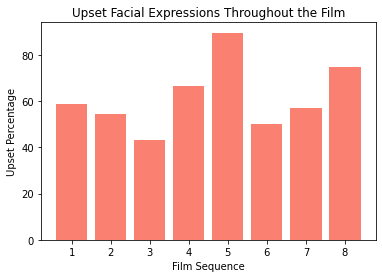

In [19]:
plot_character_filmwide_emotion(character_face_clusters, face_df)

## Dialogue Attribution
Attribution of dialogue to their speakers is a key step in understanding characters' plot and motivations. However, the results are a little shaky. The algorithm attributes dialogue by determining who's onscreen with their mouth open when a line is delivered, and this isn't always accurate.

The remainder of this notebook contains dialogue possibly attributed to Ben.

In [20]:
display_character_dialogue_context(character_face_clusters, sentence_df, nlp)

------------------
Directed Questions
------------------
You're super high, aren't you?
Should you be in the bathroom?
Where, uh... Holy shit, are you the house?
Have you ever had a real shave before, Drew?
How the hell did you do that?
What else can you do?

-------------------------------------
Possible Important Terms, Noun Groups
-------------------------------------
['the weed', 'my top-shelf shit', 'bro', 'This strain', 'the Amazon']

-------------------------
First-Person Declarations
-------------------------
I even canceled my workout with Flavio.
Anyways, I guess a lot of the house functions run off this app, so I'll send you guys the link.
Was I being...
I'm sorry, was I being an asshole?
No, I don't know what you mean.
If I don't wake up Kayla and Devon, they're gonna sleep all day.

-----------------------
Second-Person Addresses
-----------------------
Where, uh... Holy shit, are you the house?
How the hell did you do that?
What else can you do?
No, I don't know what you 